In [1]:
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, log_loss, roc_auc_score, RocCurveDisplay, roc_curve
import wandb
from wandb.sklearn import plot_precision_recall, plot_feature_importances
from wandb.sklearn import plot_class_proportions, plot_learning_curve, plot_roc
import numpy as np
import pandas as pd
from IMPJ import DataProcessor
import random
import matplotlib.pyplot as plt
from os.path import basename, exists
import matplotlib as mpl


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
        
download('https://github.com/AllenDowney/AstronomicalData/raw/main/' + 'az-paper-twocol.mplstyle')
plt.style.use('./az-paper-twocol.mplstyle')

In [2]:
dp = DataProcessor()
test_size = 0.3
n=12
filepath = '..\\Fermi-LAT Data\\fl_wrappered_' + str(n) + '.csv'
datum = pd.read_csv(filepath, index_col=0)
data = pd.read_csv(filepath, index_col=0)
X,Y = dp.choose_2_vars('CLASS1',data,1,2)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size,random_state=4) 
scaler = StandardScaler()  
scaler.fit(x_train)  
x_train = scaler.transform(x_train)  
x_test = scaler.transform(x_test)  

In [3]:
print(datum.columns)

Index(['CLASS1', 'Frac_Variability', 'HR_24', 'Signif_Avg', 'Pivot_Energy',
       'HR_35', 'HR_37', 'LP_Flux_Density', 'HR_36', 'HR_47', 'HR_57',
       'PLEC_ExpfactorS', 'HR_46'],
      dtype='object')


In [4]:

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
hl_list = []
for i in range(1,100):
        for k in range(1,100):
               
                hl_list.append((i,k))

model_parameters = {
        'hidden_layer_sizes':hl_list,
        'activation':['tanh','relu'],
        'solver':['lbfgs','sgd','adam'],
        'learning_rate':['constant','invscaling','adaptive']
}
NN = MLPClassifier(random_state=1)
clf = RandomizedSearchCV(NN, model_parameters, n_jobs=-1, cv=20,scoring='roc_auc')
clf.fit(x_train, y_train)
#NN = MLPClassifier(activation='relu', alpha= 0.0001, hidden_layer_sizes=(30,20,10), learning_rate='constant', solver='sgd', random_state=1, max_iter=10000)

# All results
#means = clf.cv_results_['mean_test_score']
#stds = clf.cv_results_['std_test_score']
#for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

print('Best parameters found:\n', clf.best_params_ )
print('Best Score (ROC-AUC) was: \n', clf.best_score_)


Best parameters found:
 {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (5, 36), 'activation': 'relu'}
Best Score (ROC-AUC) was: 
 0.9654725970643939


C:\Users\ioanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [5]:
NN = MLPClassifier(activation='tanh',hidden_layer_sizes=(50,50),learning_rate='constant',solver='sgd',max_iter=5000,random_state=1)
BNN = BaggingClassifier(estimator=NN,n_estimators=20,bootstrap=True)

In [6]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', BNN)
])

# Fit the pipeline on the training data

BNN.fit(x_train,y_train)
y_pred = BNN.predict(x_test)
y_proba = BNN.predict_proba(x_test)

accuracy = accuracy_score(y_test, y_pred)*100
confusion = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test,y_pred)
roc_auc_weightedavg = roc_auc_score(y_test,y_pred,average='weighted')
logloss = log_loss(y_test,y_pred)
f1 = f1_score(y_test,y_pred)
fpr, tpr, thresholds = roc_curve(y_test,y_proba.T[1])
resultcols = ['Accuracy', 'ROC AUC', 'ROC Weighted Av', 'Logarithmic Loss', 
            'F1 Score', 'CMatrix11','CMatrix12', 'CMatrix21', 'CMatrix22']
resultarray = np.array((accuracy,roc_auc,roc_auc_weightedavg,logloss,f1,
                        confusion[0,0],confusion[0,1],confusion[1,0],confusion[1,1]))
rocresultcols = ['FPR','TPR','Thresholds']
rocresultarray = np.array([fpr,tpr,thresholds])
print(rocresultarray.shape)
#print(rocresultarray)
results = pd.DataFrame([resultarray],columns=resultcols)
rocresults = pd.DataFrame(np.array([fpr,tpr,thresholds]).transpose(),columns=rocresultcols)
print(results['ROC AUC'])
#results.to_csv('..\\Filter_Feature_Selection_Results\\num'+str(i)+'.csv')



(3, 62)
0    0.907354
Name: ROC AUC, dtype: float64


The Neural Network accuracy is 91.56626506024097
The Neural Network ROC AUC Scores are: 0.9073539831966798
The Neural Network's Weighted Average ROC AUC Score is: 0.9073539831966798
The Neural Network's Logarithmic Loss Score is: 3.0398261894436156
The Neural Network F1 Score is: 0.8813559322033898
The Neural Network Confusion Matrix is:
[[250  17]
 [ 18 130]]
(3, 62)


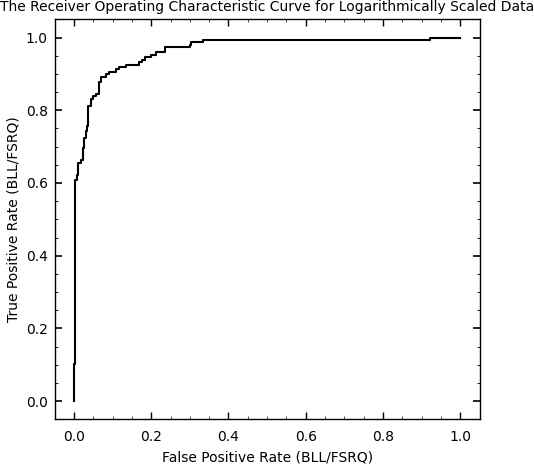

In [7]:
''' SCORING METRICS '''

accuracy = accuracy_score(y_test, y_pred)*100
confusion = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test,y_pred)
roc_auc_weightedavg = roc_auc_score(y_test,y_pred,average='weighted')
logloss = log_loss(y_test,y_pred)
f1 = f1_score(y_test,y_pred)
fpr, tpr, thresholds = roc_curve(y_test,y_proba.T[1])

print('The Neural Network accuracy is ' + str(accuracy))
print('The Neural Network ROC AUC Scores are: '+str(roc_auc))
print("The Neural Network's Weighted Average ROC AUC Score is: " + str(roc_auc_weightedavg))
print("The Neural Network's Logarithmic Loss Score is: " + str(logloss))
print('The Neural Network F1 Score is: '+str(f1))
print('The Neural Network Confusion Matrix is:')
print(confusion)

resultcols = ['Params','Accuracy', 'ROC AUC', 'ROC Weighted Av', 'Logarithmic Loss', 
              'F1 Score', 'CMatrix11','CMatrix12', 'CMatrix21', 'CMatrix22']
resultarray = np.array((clf.best_params_,accuracy,roc_auc,roc_auc_weightedavg,logloss,f1,
                        confusion[0,0],confusion[0,1],confusion[1,0],confusion[1,1]))
rocresultcols = ['FPR','TPR','Thresholds']
rocresultarray = np.array([fpr,tpr,thresholds])
print(rocresultarray.shape)
#print(rocresultarray)
results = pd.DataFrame([resultarray],columns=resultcols)
rocresults = pd.DataFrame(np.array([fpr,tpr,thresholds]).transpose(),columns=rocresultcols)

#results.to_csv('/content/drive/My Drive/Colab Notebooks/testresults.csv')
#rocresults.to_csv('/content/drive/My Drive/Colab Notebooks/testrocresults.csv')
results.to_csv('..\\Hyperparam_results\\2layer_0.csv')
rocresults.to_csv('..\\Hyperparam_results\\2layer_roc_0.csv')



mpl.rcParams['figure.dpi'] = 100
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(fpr,tpr)
ax.set_ylabel('True Positive Rate (BLL/FSRQ)')
ax.set_xlabel('False Positive Rate (BLL/FSRQ)')

#RocCurveDisplay.from_estimator(pipeline, x_test, y_test,ax=ax).figure_
plt.title('The Receiver Operating Characteristic Curve for Logarithmically Scaled Data')
plt.show()

In [8]:
# Saving the run to WandB
'''
BNN_params = BNN.get_params
wandb.init(project='final-year-project', config=BNN_params)
wandb.config.update({"test_size" : test_size,
                    "train_len" : len(x_train),
                    "test_len" : len(x_test)})

plot_class_proportions(y_train, y_test, labels)
plot_learning_curve(BNN, x_train, y_train)
plot_roc(y_test, y_proba, labels)
plot_precision_recall(y_test, y_proba, labels)
#plot_feature_importances(model)

# [optional] finish the wandb run, necessary in notebooks
wandb.finish()
'''

'\nBNN_params = BNN.get_params\nwandb.init(project=\'final-year-project\', config=BNN_params)\nwandb.config.update({"test_size" : test_size,\n                    "train_len" : len(x_train),\n                    "test_len" : len(x_test)})\n\nplot_class_proportions(y_train, y_test, labels)\nplot_learning_curve(BNN, x_train, y_train)\nplot_roc(y_test, y_proba, labels)\nplot_precision_recall(y_test, y_proba, labels)\n#plot_feature_importances(model)\n\n# [optional] finish the wandb run, necessary in notebooks\nwandb.finish()\n'

(415, 12)


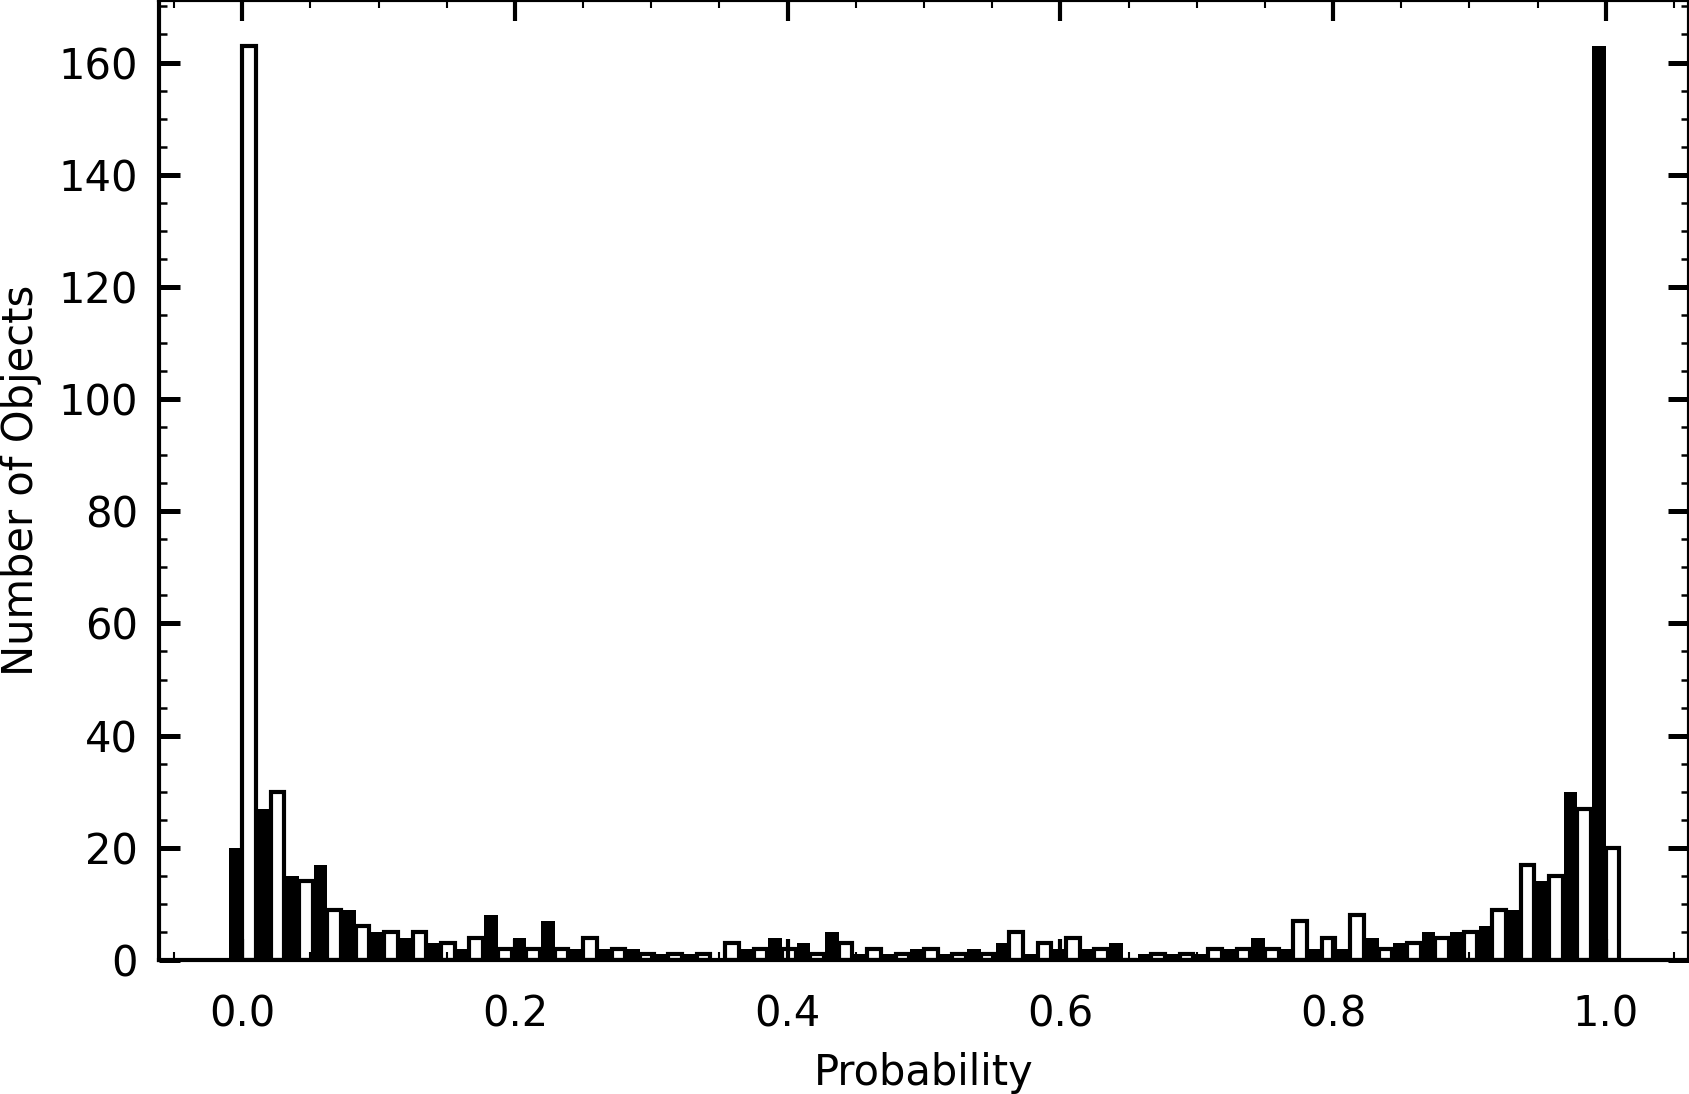

In [9]:
import matplotlib.pyplot as plt
#print(y_proba)
probs = pd.DataFrame(y_proba,columns=('p_1','p_2'))
bin_probs_1 = pd.cut(probs['p_1'],np.linspace(0,1,50),include_lowest=True)
bin_probs_2 = pd.cut(probs['p_2'],np.linspace(0,1,50),include_lowest=True)

print(x_test.shape)

fig, ax = plt.subplots(figsize=(6,4),dpi=300)
x_axis = np.linspace(0,1,len(bin_probs_1.value_counts()))

ax.bar(x_axis-0.005,bin_probs_1.value_counts(sort=False), width=0.01,label='BLLs')
ax.bar(x_axis+0.005,bin_probs_2.value_counts(sort=False),width=0.01,label='FSRQs',color='white',edgecolor='black')
#ax.legend()
ax.set_xlabel('Probability')
ax.set_ylabel('Number of Objects')
ax.set_title('')

plt.show()

In [10]:
data = pd.read_csv(filepath, index_col=0)
X,Y = dp.choose_2_vars('CLASS1',data,1,2)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size,random_state=4) 
scaler = StandardScaler()  
rdgcount = 0
data = np.array(data)
for i in range(0,len(data)):
    if data[i,0] == 3:
        rdgcount +=1
        newrow = np.delete(np.array(data[i]),0)
        x_test=np.append(x_test,[newrow],axis=0)      
scaler.fit(x_train) 
x_test = scaler.transform(x_test)  

C:\Users\ioanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


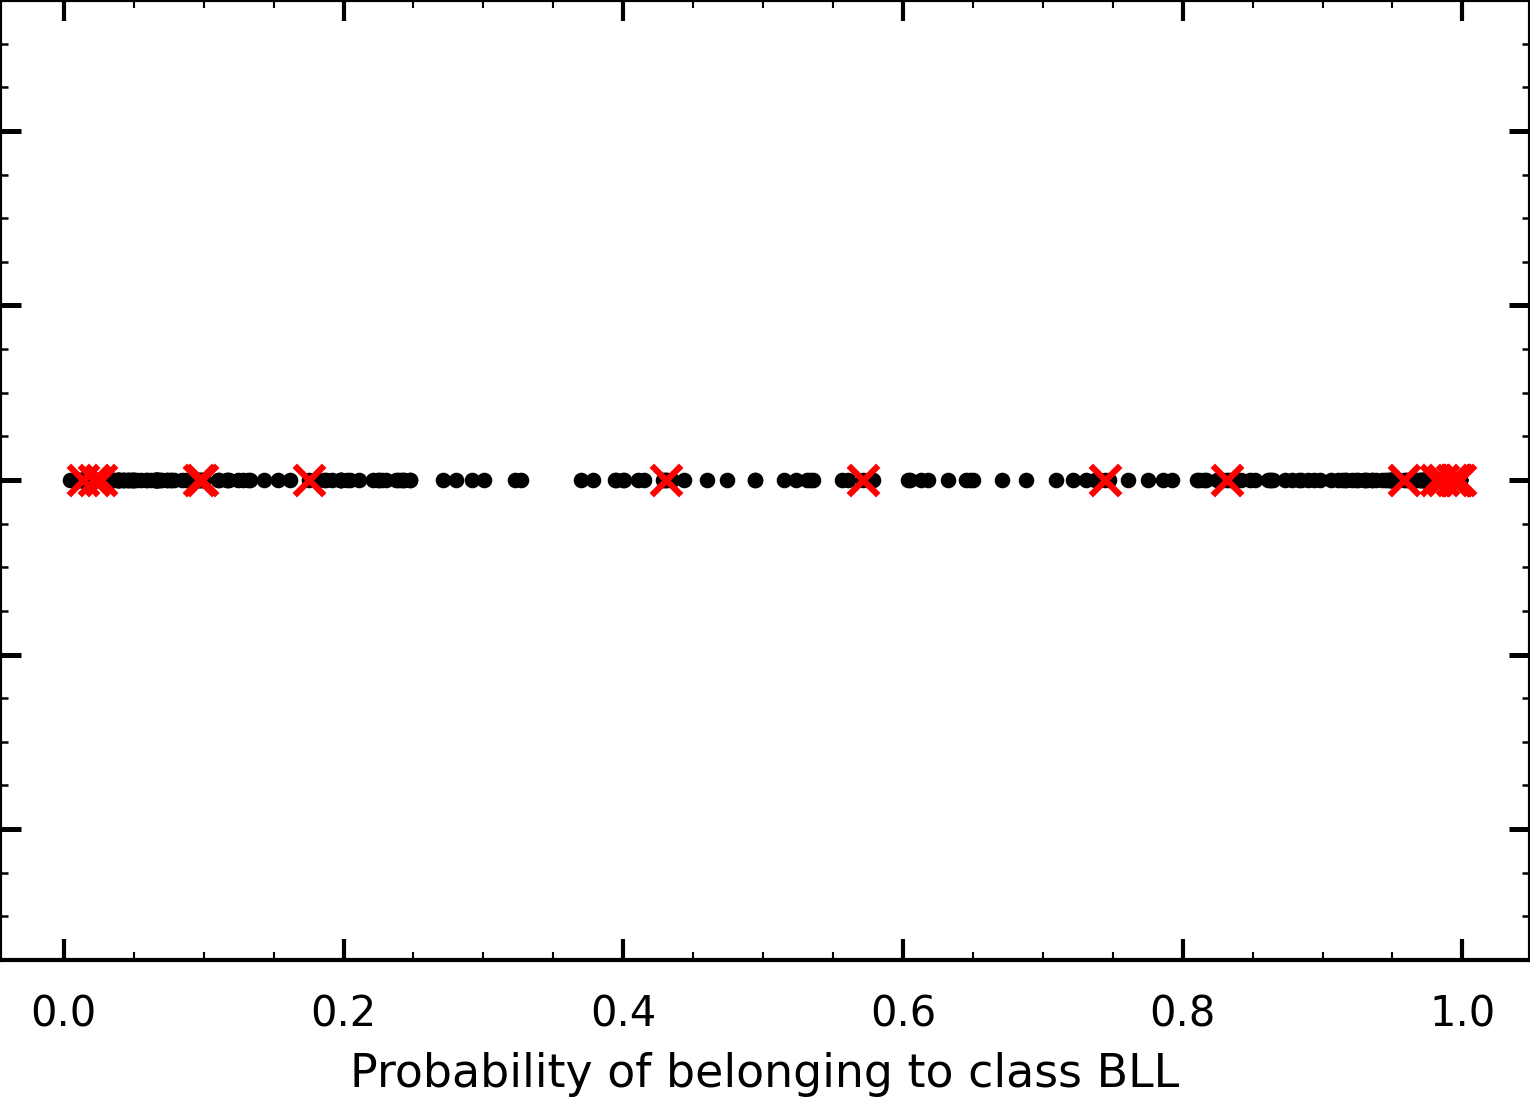

In [11]:
rdgonly=np.zeros(19)
# Fit the pipeline on the training data
for x in range(1,20):
    rdgonly[x-1] = y_proba[-x,0]

y_pred = BNN.predict(x_test)
y_proba = BNN.predict_proba(x_test)

fig, ax = plt.subplots(figsize=(6,4),dpi=300)
#x_axis = np.linspace(0,1,len(y_proba))
#print(x_axis)
#print(y_proba.T[0])
plt.scatter(np.array(y_proba.T[0]),np.zeros(len(y_proba)),marker='.',s=30)
plt.scatter(rdgonly,np.zeros(len(rdgonly)),color='red',marker='x',s=50)
ax.set_yticklabels(())
ax.set_xlabel('Probability of belonging to class BLL',fontsize=11)
plt.show()


In [38]:
data = pd.read_csv(filepath, index_col=0)
fig, ax = plt.subplots()
#plt.scatter(data['Frac_Variability'], data['HR_24'])
cols = data.columns

for j in range(0,len(cols)):
    for k in range(0,len(cols)):
        if j > k:     
            frac = np.array(data[cols[j]])
            hr = np.array(data[cols[k]])
            bllfrac=np.array([])
            bllhr = np.array([])
            fsrqfrac=np.array([])
            fsrqhr = np.array([])
            for i in range(0,len(y_pred)):
                if y_pred[i] == 0:
                    #print('bll')
                    bllfrac=np.append(bllfrac,frac[i])
                    bllhr=np.append(bllhr,hr[i])
                if y_pred[i] == 1:
                    #print('fsrq')
                    fsrqfrac=np.append(fsrqfrac,frac[i])
                    fsrqhr=np.append(fsrqhr,hr[i])

            plt.scatter(fsrqfrac,fsrqhr,color='red')
            plt.scatter(bllfrac,bllhr,color='blue')
            plt.savefig('autoplot_' + cols[j] + '_and_' + cols[k] + '.png')
            plt.clf()


<Figure size 600x300 with 0 Axes>

In [39]:
data = pd.read_csv('..\\Fermi-LAT Data\\fl_numericalonly_nopositional_withclasses.csv')


frac = np.array(data['Spectral_Index'])
hr = np.array(data['Flux1000'])
bllfrac=np.array([])
bllhr = np.array([])
fsrqfrac=np.array([])
fsrqhr = np.array([])
for i in range(0,len(y_pred)):
    if y_pred[i] == 0:
        #print('bll')
        bllfrac=np.append(bllfrac,frac[i])
        bllhr=np.append(bllhr,hr[i])
    if y_pred[i] == 1:
        #print('fsrq')
        fsrqfrac=np.append(fsrqfrac,frac[i])
        fsrqhr=np.append(fsrqhr,hr[i])

plt.scatter(fsrqfrac,fsrqhr,color='red')
plt.scatter(bllfrac,bllhr,color='blue')
plt.savefig('autoplot_' + cols[j] + '_and_' + cols[k] + '.png')
plt.clf()

KeyError: 'Spectral_Index'